### Melt pool `depth annotation` in time-resolved radiographies

In [1]:
import napari
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from magicgui import magicgui
from napari.layers import Image, Labels, Points, Shapes
from napari.types import LayerDataTuple
from napari.utils.events import Event
from skimage.exposure import rescale_intensity
from napari.utils.notifications import show_info
from typing import List

from napari.settings import get_settings


# The speed at which the movie mode runs
settings = get_settings()
settings.application.playback_fps = 40.0


# Create the viewer
viewer = napari.Viewer()


### FOREGROUND EXTRACTION ###

@magicgui(
    call_button="Adjust background",
    layout='vertical',
    threshold={"widget_type": "FloatSlider", "min": 0, "max": 1},
)
def background_segmentation(image_layer: Image, threshold: float=0.8) -> List[LayerDataTuple]:
    """Applies a gaussian filter to an image and binarizes it."""
    if image_layer is None:
        return
    
    # Intensity thresholding
    image_layer_data = image_layer.data.astype(float)
    image_layer_data = rescale_intensity(image_layer_data, out_range=(0, 1))
    labels_data = image_layer_data > threshold

    # Cropping the background (this is optional)
#     inv = (labels_data == 0).astype(np.uint8)
#     n_crop = np.sum(np.sum(inv, axis=0), axis=1)
#     to_trim = (n_crop.size - np.trim_zeros(n_crop[1:]).size)  # [1:] because first line has non-zero for some reason
#     labels_data = labels_data[:, to_trim:]
#     image_layer_data = image_layer_data[:, to_trim:]

    return [
        (labels_data, {'name': 'binary'}, 'labels'), 
        (image_layer_data, {'name': image_layer.name, 'contrast_limits': (0, 1)}, 'image')
    ]

viewer.window.add_dock_widget(background_segmentation, area='right', name='Background segmentation')


# # ### INTERPOLATE ANNOTATIONS (not working yet - also, not super useful) ###

# @magicgui(call_button="Fill missing annotations (interpolate)")
# def interpolate_depth():
#     if not 'keypoints' in [l.name for l in viewer.layers]:
#         return
        
#     keypoints = viewer.layers['keypoints'].data.astype(float)

#     y_poss = np.array([kp[1] if kp[1] > 0 else np.nan for kp in keypoints])
#     val_min, val_max = np.min(y_poss), np.max(y_poss)
#     y_poss = pd.Series(y_poss).interpolate(method='linear', limit=2)
#     y_poss = np.clip(y_poss.values, val_min, val_max)

#     for k, y in enumerate(y_poss):
#         keypoints[k, 1] = y

#     viewer.layers['keypoints'].data = keypoints#.astype(int)

# viewer.window.add_dock_widget(interpolate_depth, area='right', name='Interpolate')


### SAVING RESULTS ###

@magicgui(call_button="Save depth profile as CSV")
def save_depth_csv():
    if 'keypoints' in [l.name for l in viewer.layers]:
        keypoints = viewer.layers['keypoints'].data
        binary_data = viewer.layers['binary'].data

        df = pd.DataFrame()
        for lab, kp in zip(binary_data, keypoints):
            _, y_pos, x_pos = kp.astype(int)
            air_boundary_idx = np.trim_zeros(lab[:, x_pos]).size
            depth_px = y_pos - air_boundary_idx if y_pos > 0 else np.nan
            current_df = pd.DataFrame({"x": (x_pos,), "y": (y_pos,), "air_boundary": (air_boundary_idx,), "depth": (depth_px,)})
            df = pd.concat((df, current_df))

        # depth = pd.Series(np.asarray(depth, dtype=np.float64)).interpolate(method='linear', limit=2)
        # depth.to_csv('depth_profile.csv')
        df.to_csv("depth_data.csv")

        # points_layer.save('depth_profile.csv')
        show_info('Saved keypoints as CSV.')
    else:
        show_info('No keypoints layer found.')

viewer.window.add_dock_widget(save_depth_csv, area='right', name='Save')


### VIZ OF DEPTH AS VERTICAL LINE ###

@magicgui(
    auto_call=True, 
    layout='vertical', follow_cursor={'label': 'Follow cursor (F)'})
def keypoint_tracking(image_layer: Image, follow_cursor: bool=False) -> LayerDataTuple:
    """Cursor tracking annotation tool."""
    if image_layer is None:
        return

    if not 'keypoints' in [l.name for l in viewer.layers]:
        props = {
            'name': 'keypoints', 
            'size': 3,
            'ndim': 3,
            'edge_width': 0,
            'opacity': 0.0,
        }
        return ([[0, 0, 0]]*len(image_layer.data), props, 'points')

    if not 'depth' in [l.name for l in viewer.layers]:
        props = {
            'name':'depth', 
            'shape_type': 'line', 
            'edge_color': 'white', 
            'edge_width': 1,
            'features': {'depth': [0]},
            'text': {
                'string': '{depth:0.1f} px',
                'size': 11,
                'color': 'white',
                'translation': np.array([0, 20]),
            }
        }
        return ([[[0, 0, 0], [0, 0, 0]]], props, 'shapes')


viewer.window.add_dock_widget(keypoint_tracking, area='right', name='Annotate')

# viewer.layers.events.inserted.connect(keypoint_tracking)
# keypoint_tracking()


def scroll_slices(event: Event):
    if keypoint_tracking.follow_cursor.value:
        return
    
    if not 'keypoints' in [l.name for l in viewer.layers]:
        keypoint_tracking()

    if not 'binary' in [l.name for l in viewer.layers]:
        background_segmentation()
    
    if not 'depth' in [l.name for l in viewer.layers]:
        return
    
    current_time_step = event.value[0]
    
    points_layer = viewer.layers['keypoints']

    _, x_pos, y_pos = points_layer.data[current_time_step]
    if (x_pos + y_pos) == 0:
        return  # that point was not set.

    binary_layer = viewer.layers['binary']
    air_boundary = binary_layer.data[current_time_step, :, y_pos]
    air_boundary_idx = np.trim_zeros(air_boundary).size
    depth_px = x_pos - air_boundary_idx  # Depth in pixels
    
    depth_layer = viewer.layers['depth']
    depth_layer.data = [
        [current_time_step, air_boundary_idx, y_pos], 
        [current_time_step, x_pos, y_pos]
    ]

    depth_layer.features['depth'] = [depth_px]
    depth_layer.refresh()
    depth_layer.refresh_text()


viewer.dims.events.current_step.connect(scroll_slices)


### Depth line follows the cursor functionality ###

def follow_cursor(event: Event):
    """Updates Points layer and depth data based on cursor position."""   

    if not 'keypoints' in [l.name for l in viewer.layers]:
        keypoint_tracking()

    if not 'binary' in [l.name for l in viewer.layers]:
        background_segmentation()

    if not 'depth' in [l.name for l in viewer.layers]:
        return
    
    _, x_pos, y_pos = np.array(viewer.cursor.position).astype(int)

    current_time_step = viewer.dims.current_step[0]
    
    points_layer = viewer.layers['keypoints']
    points_layer.data[current_time_step] = [current_time_step, x_pos, y_pos]
    points_layer.refresh()

    binary_layer = viewer.layers['binary']
    air_boundary = binary_layer.data[current_time_step, :, y_pos]
    air_boundary_idx = np.trim_zeros(air_boundary).size
    depth_px = x_pos - air_boundary_idx  # Depth in pixels
    
    depth_layer = viewer.layers['depth']
    depth_layer.data = [
        [current_time_step, air_boundary_idx, y_pos], 
        [current_time_step, x_pos, y_pos]
    ]

    depth_layer.features['depth'] = [depth_px]
    depth_layer.refresh()
    depth_layer.refresh_text()


def handle_follow_cursor(event: Event):
    if keypoint_tracking.follow_cursor.value:
        # viewer.cursor.events.position.connect(follow_cursor)
        viewer.dims.events.current_step.connect(follow_cursor)
    else:
        # viewer.cursor.events.position.disconnect(follow_cursor)
        viewer.dims.events.current_step.disconnect(follow_cursor)

@viewer.bind_key('f')
def toggle_brush_follow(event: Event):
    current = keypoint_tracking.follow_cursor.value
    keypoint_tracking.follow_cursor.value = not current
    handle_follow_cursor(event)

viewer.text_overlay.visible = True
viewer.text_overlay.text = 'Press F to start/stop annotating'


### Change playback speed

In [7]:
settings.application.playback_fps = 40.0

In [ ]:
viewer.cursor

### Visualizing the melt pool depth evolution

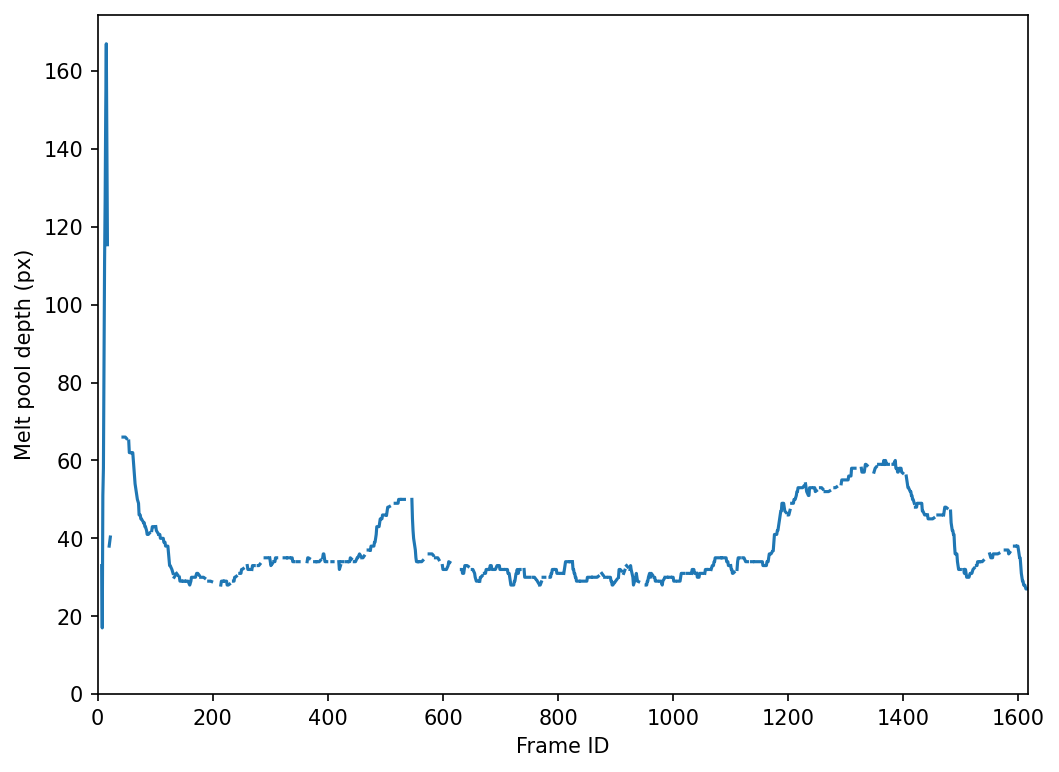

In [3]:
# From reloaded CSV (save it beforehand)

depth = pd.read_csv('depth_profile.csv').values[:, 1]

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.plot(depth)
ax.set_ylim(bottom=0)
ax.set_xlim(0, len(depth))
ax.set_xlabel('Frame ID')
ax.set_ylabel('Melt pool depth (px)')
plt.show()